<div style="
  background:#f2f4f7;                   /* soft gray-blue background */
  border-left:8px solid #708090;        /* silver spine */
  padding:20px 26px;
  border-radius:10px;
  box-shadow:0 2px 6px rgba(0,0,0,0.1);
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#1a1a1a;
">

<h1 style="
  color:#708090;
  font-size:2.4em;
  font-weight:700;
  margin-top:0;
  margin-bottom:0.2em;
">
  ⚪ Silver Notebook — Weather & Production Analysis
</h1>

<p style="
  font-size:1.15em;
  color:#2c2c2c;
  margin-top:0;
  margin-bottom:1.2em;
  text-align:justify;
">
  This notebook performs weather anomaly detection and production trend analysis
  using the Bronze-layer ERA5 and Elhub datasets.
  It identifies temperature and precipitation outliers, decomposes production trends,
  and visualizes frequency patterns.
</p>

<ul style="margin:0 0 0.6em 1em;line-height:1.55;">
  <li>Temperature outliers using DCT high-pass filtering and SPC limits.</li>
  <li>Precipitation anomalies via Local Outlier Factor (LOF).</li>
  <li>STL decomposition for trend and seasonality.</li>
  <li>Spectrogram visualization for frequency components.</li>
</ul>
</div>


In [ ]:
# We start of by importing the necessary libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import dct, idct
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram


<div style="
  background:#eaf3ff;
  border-left:6px solid #4a6fa5;
  padding:14px 20px;
  border-radius:8px;
  margin:14px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#0d1b2a;
">
<h2 style="color:#4a6fa5;margin-top:0;">Step 1 – Load Weather Data (Bergen, 2019)</h2>
<p style="margin:0.4em 0;">
We import the Bronze-layer dataset 
<code>era5_bergen_60.3913N_5.3221E_2019.csv</code> containing hourly weather data.
This forms the input for temperature and precipitation anomaly detection.
</p>
</div>


In [ ]:
# Here we import bronze-level dataset
df = pd.read_csv(
    "../Data_Assignment_3/bronze/era5_bergen_60.3913N_5.3221E_2019.csv",
    parse_dates=["time"],
    index_col="time"
)

df.head()


,temperature_2m,precipitation,windspeed_10m,windgusts_10m,winddirection_10m
time,,,,,
2019-01-01 00:00:00,5.7,0.7,37.0,99.7,263
2019-01-01 01:00:00,5.8,0.2,41.0,107.3,278
2019-01-01 02:00:00,6.1,0.7,42.0,112.0,286
2019-01-01 03:00:00,6.3,0.5,40.9,105.8,298
2019-01-01 04:00:00,5.8,1.1,41.2,110.2,315


<div style="
  background:#eef6ff;
  border-left:6px solid #3e5f8a;
  padding:14px 20px;
  border-radius:8px;
  margin:14px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#0d1b2a;
">
<h2 style="color:#3e5f8a;margin-top:0;">Step 2 – Temperature Outlier Detection (DCT + SPC)</h2>
<p style="margin:0.4em 0;">
We apply a <strong>Discrete Cosine Transform (DCT)</strong> to remove seasonal components
and obtain seasonally adjusted temperature variations (SATV).
Outliers are identified using robust SPC boundaries (median ± <em>n</em>·MAD)
and plotted in red.
</p>
</div>


In [ ]:
# we define a function to detect temperature outliers
def detect_temperature_outliers(
    df: pd.DataFrame,
    *,
    freq_cutoff: int = 60,
    n_std: float = 3.0
):
    
    if "temperature_2m" not in df.columns:
        raise KeyError("Expected column 'temperature_2m' in the input DataFrame.")

    temp = df["temperature_2m"].to_numpy(dtype=float)
    n = temp.size
    if n < 8:
        raise ValueError("Not enough points for DCT-based filtering (need at least 8).")

    # Bound the cut-off
    k = int(max(1, min(freq_cutoff, n - 1)))

    # DCT high-pass
    coeffs = dct(temp, norm="ortho")
    coeffs_hp = coeffs.copy()
    coeffs_hp[:k] = 0
    satv = idct(coeffs_hp, norm="ortho")

    # Robust stats
    median = np.median(satv)
    mad = np.median(np.abs(satv - median))
    robust_std = 1.4826 * mad

    # If series is perfectly flat after HP, avoid zero-width limits
    if robust_std == 0:
        robust_std = np.std(satv) or 1e-9

    upper = median + n_std * robust_std
    lower = median - n_std * robust_std

    # Outliers (based on SATV)
    outlier_mask = (satv > upper) | (satv < lower)
    n_outliers = int(outlier_mask.sum())

    # Plot original temperature with outliers highlighted
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df.index, df["temperature_2m"], label="Temperature (°C)", linewidth=1)
    ax.scatter(
        df.index[outlier_mask],
        df["temperature_2m"][outlier_mask],
        s=15, label="Outliers"
    )
    ax.set_title("Temperature with Outliers (DCT high-pass SPC)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    summary = pd.DataFrame({
        "timestamp": df.index[outlier_mask],
        "temperature_2m": df["temperature_2m"].to_numpy()[outlier_mask],
        "satv": satv[outlier_mask],
        "lower_bound": lower,
        "upper_bound": upper,
    }).reset_index(drop=True)

    print(f"{n_outliers} outliers detected ({100 * n_outliers / n:.2f}% of points)")
    return fig, summary


50 outliers detected (0.57% of points)


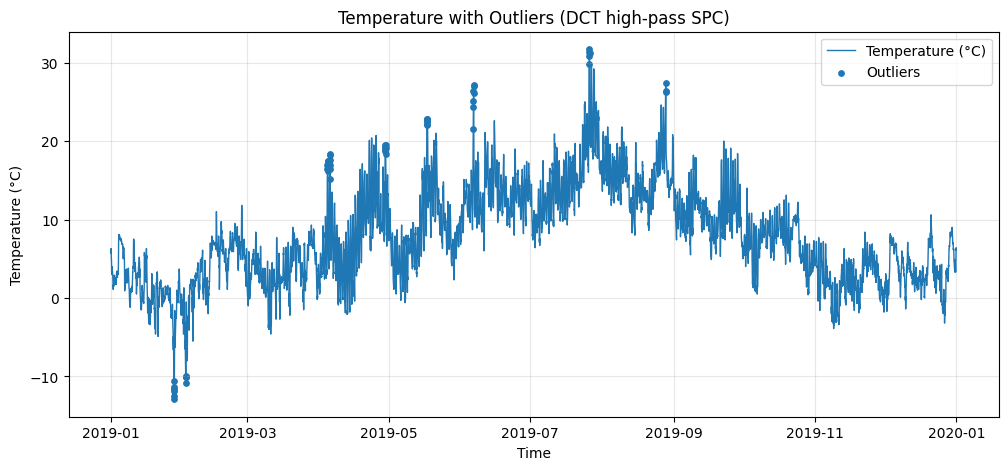

,timestamp,temperature_2m,satv,lower_bound,upper_bound
0,2019-01-28 05:00:00,-10.6,-8.825264,-7.96657,7.905624
1,2019-01-28 06:00:00,-11.3,-9.514296,-7.96657,7.905624
2,2019-01-28 07:00:00,-11.8,-10.003452,-7.96657,7.905624
3,2019-01-28 08:00:00,-11.6,-9.792736,-7.96657,7.905624
4,2019-01-28 09:00:00,-12.9,-11.082149,-7.96657,7.905624
5,2019-01-28 10:00:00,-12.5,-10.671691,-7.96657,7.905624
6,2019-02-02 07:00:00,-10.1,-8.251575,-7.96657,7.905624
7,2019-02-02 08:00:00,-10.1,-8.263756,-7.96657,7.905624
8,2019-02-02 09:00:00,-10.8,-8.976170,-7.96657,7.905624
9,2019-02-02 10:00:00,-9.9,-8.088818,-7.96657,7.905624


In [ ]:
fig_temp, temp_summary = detect_temperature_outliers(df, freq_cutoff=60, n_std=3.0)
plt.show()
temp_summary.head(10)


<div style="
  background:#f0f8ff;
  border-left:6px solid #2f5a91;
  padding:14px 20px;
  border-radius:8px;
  margin:14px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#0d1b2a;
">
<h2 style="color:#2f5a91;margin-top:0;">Step 3 – Precipitation Anomalies (Local Outlier Factor)</h2>
<p style="margin:0.4em 0;">
We use the <strong>Local Outlier Factor (LOF)</strong> method to detect precipitation anomalies,
defaulting to a 1% contamination rate.
Anomalies are plotted in contrasting colors, highlighting extreme weather events.
</p>
</div>


In [ ]:
def detect_precip_lof(df: pd.DataFrame, prop_outliers: float = 0.01):
    if "precipitation" not in df.columns:
        raise KeyError("DataFrame must contain a 'precipitation' column.")

    z = df[["precipitation"]].copy()
    z["precipitation"] = z["precipitation"].astype(float).fillna(0.0)

    lof = LocalOutlierFactor(contamination=prop_outliers)
    y_pred = lof.fit_predict(z)  # -1 = outlier, 1 = inlier

    outlier_mask = (y_pred == -1)
    outliers = df.loc[outlier_mask, ["precipitation"]].copy()

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df.index, df["precipitation"], label="Precipitation (mm)")
    ax.scatter(outliers.index, outliers["precipitation"], label="Anomaly (LOF)", s=15)
    ax.set_title(f"Precipitation anomalies via LOF (contamination={prop_outliers:.1%})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Precipitation (mm)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    summary = outliers["precipitation"].describe()
    return fig, outliers.reset_index().rename(columns={"index": "timestamp"}), summary


c:\Users\joeri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


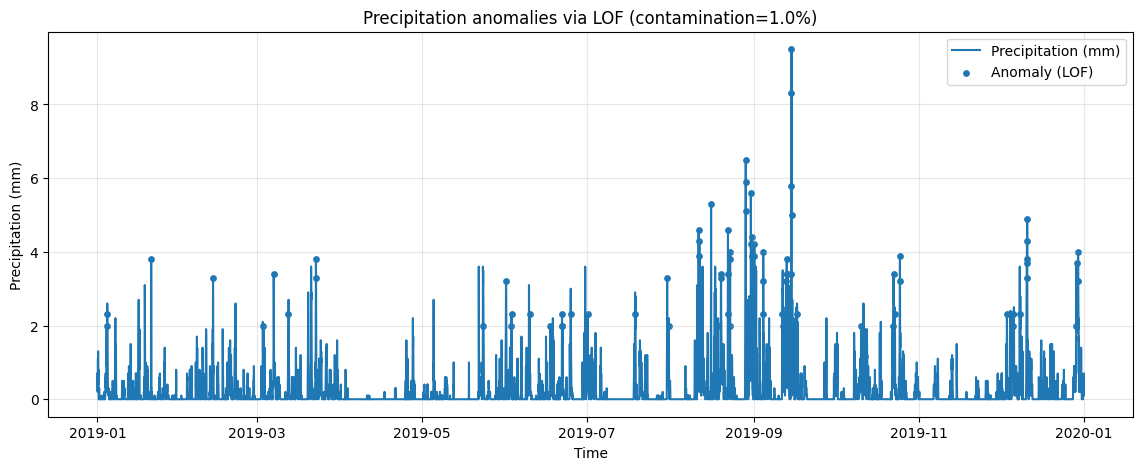

,time,precipitation
0,2019-01-04 09:00:00,2.0
1,2019-01-04 16:00:00,2.3
2,2019-01-20 21:00:00,3.8
3,2019-02-12 18:00:00,3.3
4,2019-03-03 05:00:00,2.0


In [ ]:
fig_precip, precip_outliers, precip_summary = detect_precip_lof(df, prop_outliers=0.01)
plt.show()
precip_outliers.head()


<div style="
  background:#edf3f6;
  border-left:6px solid #6a7c8e;
  padding:14px 20px;
  border-radius:8px;
  margin:14px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#1a1a1a;
">
<h2 style="color:#6a7c8e;margin-top:0;">Step 4 – Load Elhub Production Data</h2>
<p style="margin:0.4em 0;">
We import <code>production_2021.csv</code> from the Elhub Bronze layer.
The dataset includes hourly production quantities grouped by
price area and production type (e.g., Hydro, Wind).
</p>
</div>


In [ ]:
# We'll try to load a bronze CSV exported by assignment-2.
# Adjust BASE and candidate paths if your layout differs.
BASE = Path("..") / "Assignment_2_medailon"  # relative from Assignment_3_medailon/silver.ipynb
BRONZE_CANDIDATES = [
    BASE / "bronze" / "elhub_production_2021.csv",
    BASE / "bronze" / "elhub_production.csv",
    BASE / "bronze" / "elhub" / "production_2021.csv",
    BASE / "bronze" / "elhub" / "production.csv",
]


In [ ]:
def load_elhub_bronze():
    # we start by checking for in-memory exports from assignment-2 if this notebook is run in the same kernel/session
    for var_name in ("df_clean", "df_months", "df"):
        if var_name in globals():
            x = globals()[var_name]
            if isinstance(x, pd.DataFrame) and not x.empty and \
                {"priceArea","productionGroup","startTime","quantityKwh"}.issubset(x.columns):
                y = x.copy()
                y["startTime"] = pd.to_datetime(y["startTime"], utc=True, errors="coerce")
                y = y.dropna(subset=["startTime"]).set_index("startTime").sort_index()
                return y

    # Now load from disk (bronze CSV)
    for p in BRONZE_CANDIDATES:
        if p.exists():
            df = pd.read_csv(p, parse_dates=["startTime"])
            df = df.dropna(subset=["startTime","priceArea","productionGroup","quantityKwh"])
            df["priceArea"] = df["priceArea"].astype(str).str.upper()
            df["productionGroup"] = df["productionGroup"].astype(str).str.upper()
            df["quantityKwh"] = pd.to_numeric(df["quantityKwh"], errors="coerce")
            df = df.dropna(subset=["quantityKwh"])
            return df.set_index("startTime").sort_index()

    raise FileNotFoundError(
        "Elhub bronze data not found.\n"
        "Export df_clean from Assignment_2_medailon/assignment-2.ipynb to one of:\n  - "
        + "\n  - ".join(str(p) for p in BRONZE_CANDIDATES)
    )

# Load Elhub bronze data, to be used later
elhub_bronze = pd.read_csv("../Data_Assignment_2/bronze/production_2021.csv")
elhub_bronze.head()


,priceArea,productionGroup,startTime,quantityKwh
0,NO1,HYDRO,2025-10-07 14:00:00+00:00,2491476.5
1,NO1,HYDRO,2025-10-07 15:00:00+00:00,2482574.8
2,NO1,HYDRO,2025-10-07 16:00:00+00:00,2485451.8
3,NO1,HYDRO,2025-10-07 17:00:00+00:00,2449597.5
4,NO1,HYDRO,2025-10-07 18:00:00+00:00,2274894.0


<div style="
  background:#e7f0f5;
  border-left:6px solid #567286;
  padding:14px 20px;
  border-radius:8px;
  margin:14px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#102538;
">
<h2 style="color:#567286;margin-top:0;">Step 5 – STL Decomposition (LOESS)</h2>
<p style="margin:0.4em 0;">
We apply <strong>Seasonal-Trend decomposition using LOESS (STL)</strong> to the Elhub production data.
This separates the observed signal into <em>trend</em>, <em>seasonal</em>, and <em>residual</em> components,
enabling detailed trend interpretation.
</p>
</div>


In [ ]:
# Function to select and process production series from Elhub bronze data
def _select_production_series_elhub(
    df: pd.DataFrame,
    value_col: str = "quantityKwh",
    price_area: str | None = "NO5",
    production_group: str | None = None,
    resample_rule: str = "H",  # hourly
    agg: str = "sum",          # production is commonly sum per hour
    fill_method: str = "interpolate",  # interpolate | ffill | zero
) -> pd.Series:
    x = df.copy()

    # Ensure DatetimeIndex
    if not isinstance(x.index, pd.DatetimeIndex):
        if "startTime" in x.columns:
            x["startTime"] = pd.to_datetime(x["startTime"], utc=True, errors="coerce")
            x = x.dropna(subset=["startTime"]).set_index("startTime").sort_index()
        else:
            raise ValueError("Expected 'startTime' or a DatetimeIndex.")

    # Optional filters if columns exist
    if price_area is not None and "priceArea" in x.columns:
        x = x[x["priceArea"] == price_area.upper()]
    if production_group is not None and "productionGroup" in x.columns:
        x = x[x["productionGroup"] == production_group.upper()]

    if value_col not in x.columns:
        raise KeyError(f"Value column '{value_col}' not in columns: {x.columns.tolist()[:12]}...")

    # Resample to regular grid
    if agg == "sum":
        y = x[value_col].resample(resample_rule).sum()
    elif agg == "mean":
        y = x[value_col].resample(resample_rule).mean()
    else:
        raise ValueError("agg must be 'sum' or 'mean'.")

    # Fill gaps
    if fill_method == "interpolate":
        y = y.interpolate(limit_direction="both")
    elif fill_method == "ffill":
        y = y.ffill().bfill()
    elif fill_method == "zero":
        y = y.fillna(0.0)
    else:
        raise ValueError("fill_method must be interpolate|ffill|zero")

    return y.astype("float64")


In [ ]:
# Function to perform STL decomposition on Elhub production data
def stl_decompose_production_elhub(
    df: pd.DataFrame,
    *,
    value_col: str = "quantityKwh",
    price_area: str | None = "NO5",
    production_group: str | None = None,
    resample_rule: str = "H",
    agg: str = "sum",
    period: int = 24,
    seasonal: int = 13,
    trend: int = 201,
    robust: bool = True,
):
    # Validate odd windows where applicable
    if seasonal % 2 == 0:
        raise ValueError("`seasonal` must be an odd integer.")
    if trend % 2 == 0:
        raise ValueError("`trend` must be an odd integer.")

    y = _select_production_series_elhub(
        df=df,
        value_col=value_col,
        price_area=price_area,
        production_group=production_group,
        resample_rule=resample_rule,
        agg=agg,
        fill_method="interpolate",
    )

    stl = STL(y, period=period, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()

    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(y.index, y.values, linewidth=1)
    axes[0].set_title(
        f"Elhub Production — {price_area or 'All'}"
        f"{' / ' + production_group if production_group else ''}"
        f"  (rule={resample_rule}, period={period}, seasonal={seasonal}, trend={trend}, robust={robust})"
    )
    axes[0].set_ylabel("Observed (kWh)")

    axes[1].plot(y.index, res.trend, linewidth=1);     axes[1].set_ylabel("Trend")
    axes[2].plot(y.index, res.seasonal, linewidth=1);  axes[2].set_ylabel("Seasonal")
    axes[3].plot(y.index, res.resid, linewidth=1);     axes[3].set_ylabel("Remainder"); axes[3].set_xlabel("Time")

    for ax in axes:
        ax.grid(True, alpha=0.3)

    fig.tight_layout()
    return fig, res


C:\Users\joeri\AppData\Local\Temp\ipykernel_29692\489253386.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = x[value_col].resample(resample_rule).sum()


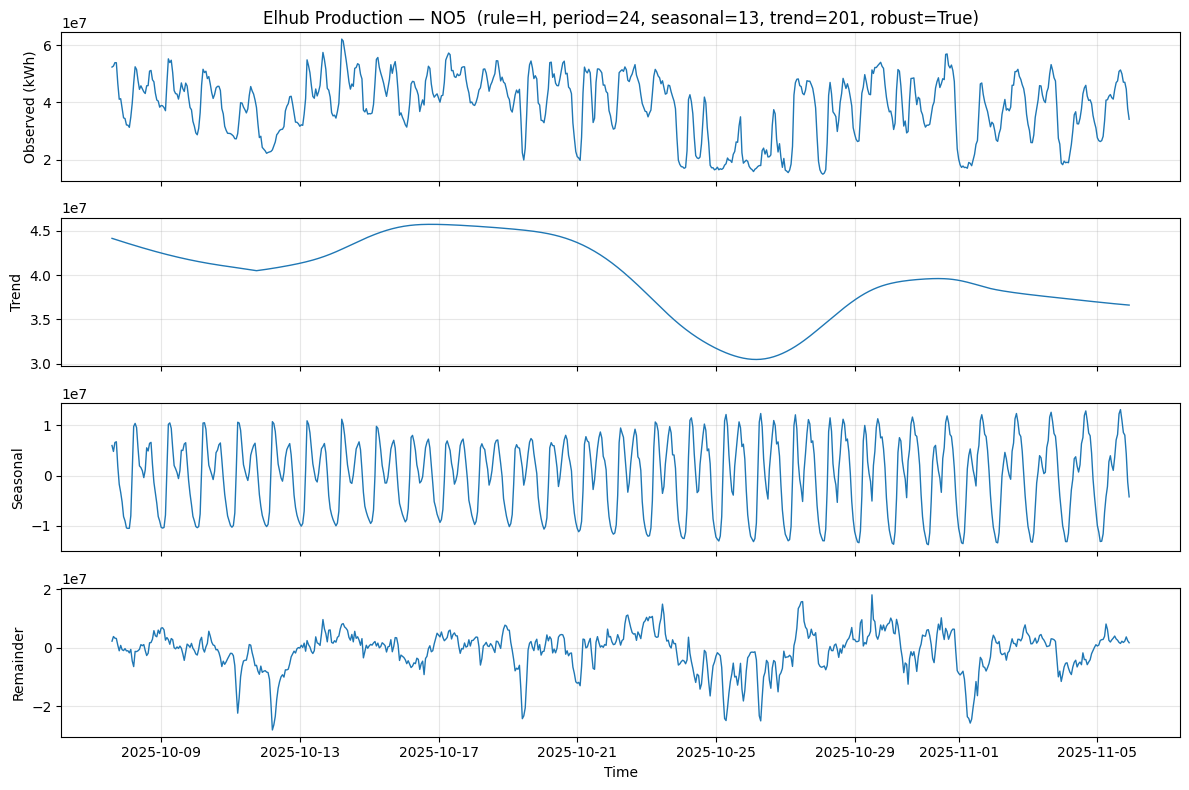

In [ ]:
fig_stl, stl_res = stl_decompose_production_elhub(
    elhub_bronze,
    value_col="quantityKwh",
    price_area="NO5",
    production_group=None,
    resample_rule="H",
    period=24,
    seasonal=13,
    trend=201,
    robust=True,
)
plt.show()


<div style="
  background:#eef7fb;
  border-left:6px solid #2c5673;
  padding:14px 20px;
  border-radius:8px;
  margin:14px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#0d1b2a;
">
<h2 style="color:#2c5673;margin-top:0;">Step 6 – Spectrogram Analysis</h2>
<p style="margin:0.4em 0;">
We generate a <strong>spectrogram</strong> of Elhub production data
to visualize periodic patterns and frequency components over time.
This helps identify operational cycles or recurring production behaviors.
</p>
</div>


In [ ]:
def spectrogram_production_elhub(
    df: pd.DataFrame,
    *,
    value_col: str = "quantityKwh",
    price_area: str | None = "NO5",
    production_group: str | None = None,
    window_length: int = 24 * 14,
    overlap: float = 0.5,
    detrend: str = "constant",
    scaling: str = "density",
    cmap: str = "viridis",
):
    """
    Create a spectrogram of Elhub production.
    Expects columns: priceArea, productionGroup, quantityKwh, startTime (or a DatetimeIndex).
    """
    x = df.copy()

    if not isinstance(x.index, pd.DatetimeIndex):
        if "startTime" not in x.columns:
            raise TypeError("DataFrame must have a DatetimeIndex or a 'startTime' column.")
        x["startTime"] = pd.to_datetime(x["startTime"], utc=True, errors="coerce")
        x = x.dropna(subset=["startTime"]).set_index("startTime")
    x = x.sort_index()

    if price_area is not None:
        if "priceArea" in x.columns:
            x = x[x["priceArea"].astype(str).str.upper() == price_area.upper()]
        else:
            raise KeyError("Column 'priceArea' not found in DataFrame.")
    if production_group is not None:
        if "productionGroup" in x.columns:
            x = x[x["productionGroup"].astype(str).str.upper() == production_group.upper()]
        else:
            raise KeyError("Column 'productionGroup' not found in DataFrame.")

    if x.empty:
        pa_list = sorted(df.get("priceArea", pd.Series(dtype=str)).astype(str).str.upper().unique().tolist())
        pg_list = sorted(df.get("productionGroup", pd.Series(dtype=str)).astype(str).str.upper().unique().tolist())
        raise ValueError(
            f"No data after filters (price_area={price_area}, production_group={production_group}).\n"
            f"Available priceArea: {pa_list}\nAvailable productionGroup: {pg_list}"
        )

    if value_col not in x.columns:
        raise KeyError(f"Value column '{value_col}' not found. Available: {list(x.columns)[:12]} ...")

    y = x[value_col].resample("H").sum().astype("float64")
    y = y.interpolate(limit_direction="both")
    if y.size < 3:
        raise ValueError("Not enough points after resampling for spectrogram.")

    dt_ns = np.median(np.diff(y.index.asi8))
    dt_hours = dt_ns / 3.6e12
    fs = 1.0 / dt_hours if dt_hours > 0 else 1.0

    nperseg = int(window_length)
    if not (0.0 <= overlap < 1.0):
        raise ValueError("overlap must be in [0, 1).")
    noverlap = int(overlap * nperseg)
    if noverlap >= nperseg:
        noverlap = nperseg - 1

    f, t, Sxx = spectrogram(
        y.values, fs=fs, window="hann",
        nperseg=nperseg, noverlap=noverlap,
        detrend=detrend, scaling=scaling, mode="psd",
    )

    t0 = y.index[0]
    t_datetime = pd.to_datetime(t0) + pd.to_timedelta(t, unit="h")

    fig, ax = plt.subplots(figsize=(12, 5))
    mesh = ax.pcolormesh(t_datetime, f, Sxx, shading="gouraud", cmap=cmap)
    ax.set_title(
        "Elhub Production Spectrogram"
        + (f" — {price_area}" if price_area else "")
        + (f" / {production_group}" if production_group else "")
        + f"  (window={nperseg}, overlap={overlap:.0%})"
    )
    ax.set_ylabel("Frequency (cycles/hour)")
    ax.set_xlabel("Time")
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label("Power")
    ax.set_ylim(0, f.max())
    ax.grid(True, alpha=0.2)
    fig.tight_layout()

    return fig, (f, t_datetime, Sxx)


C:\Users\joeri\AppData\Local\Temp\ipykernel_29692\3888854946.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = x[value_col].resample("H").sum().astype("float64")


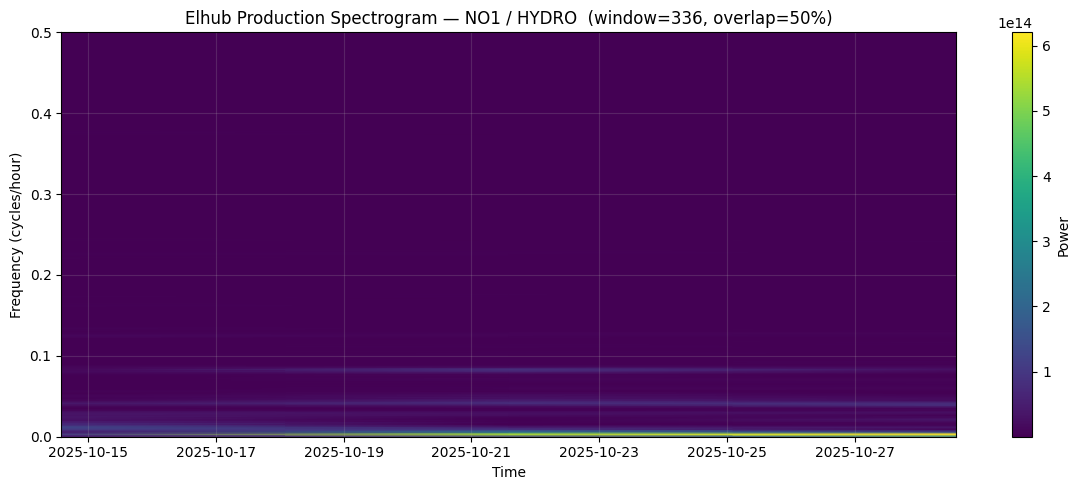

In [ ]:
fig_spec, (f, t_dt, Sxx) = spectrogram_production_elhub(
    elhub_bronze,
    value_col="quantityKwh",
    price_area="NO1",
    production_group="HYDRO",
    window_length=24*14,
    overlap=0.5,
)
plt.show()


<div style="
  background:#f5f6f8;
  border-left:6px solid #708090;
  padding:16px 22px;
  border-radius:8px;
  margin:18px 0;
  font-family:Georgia,'Book Antiqua','Palatino Linotype',serif;
  color:#1a1a1a;
">
<h2 style="color:#708090;margin-top:0;">Summary</h2>
<ul style="margin:0.4em 0 0.6em 1em;line-height:1.55;">
  <li>Temperature outliers and precipitation anomalies successfully detected.</li>
  <li>STL decomposition revealed seasonal and trend structures in production data.</li>
  <li>Spectrogram analysis visualized repeating frequency patterns.</li>
</ul>
<p style="margin:0;">
These analyses complete the <strong>Silver layer</strong> of the pipeline,
producing clean, analyzed data ready for visualization in the Gold layer.
</p>
</div>


2019-01-01 00:00:00 2019-12-31 23:00:00
50 outliers detected (0.57% of points)


c:\Users\joeri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
C:\Users\joeri\AppData\Local\Temp\ipykernel_29692\489253386.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = x[value_col].resample(resample_rule).sum()


count    85.000000
mean      3.340000
std       1.401886
min       2.000000
25%       2.300000
50%       3.300000
75%       3.900000
max       9.500000
Name: precipitation, dtype: float64


C:\Users\joeri\AppData\Local\Temp\ipykernel_29692\3888854946.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = x[value_col].resample("H").sum().astype("float64")


(169, 3)

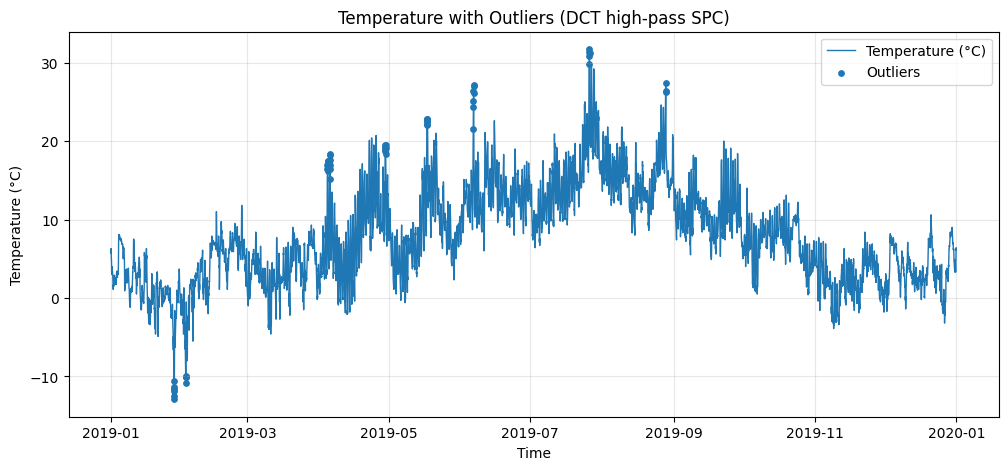

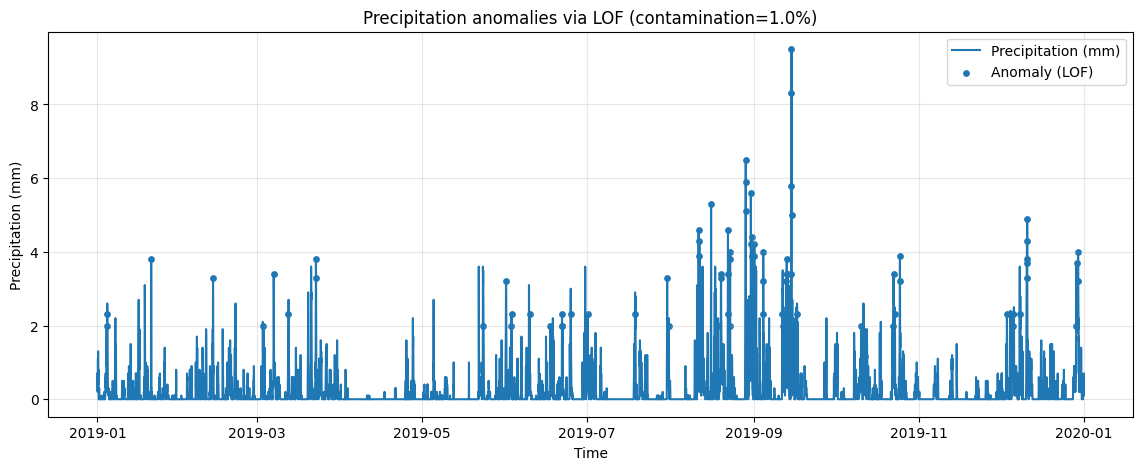

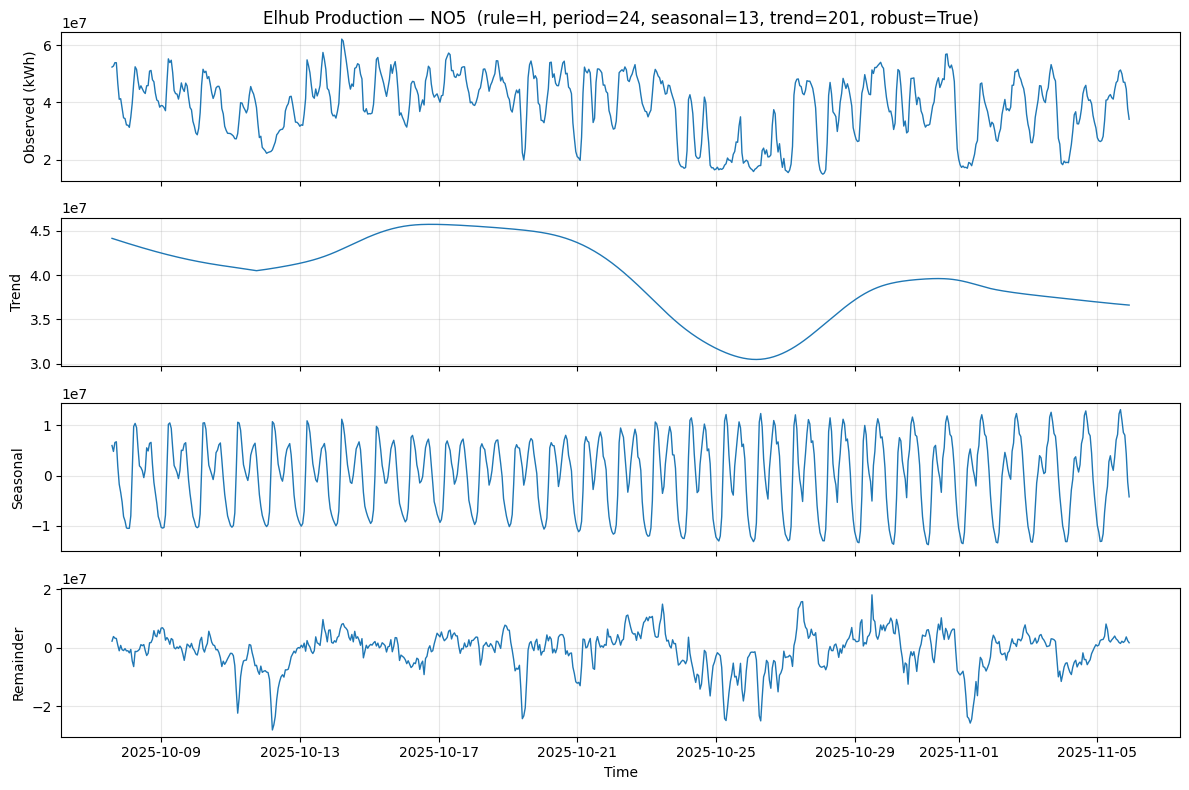

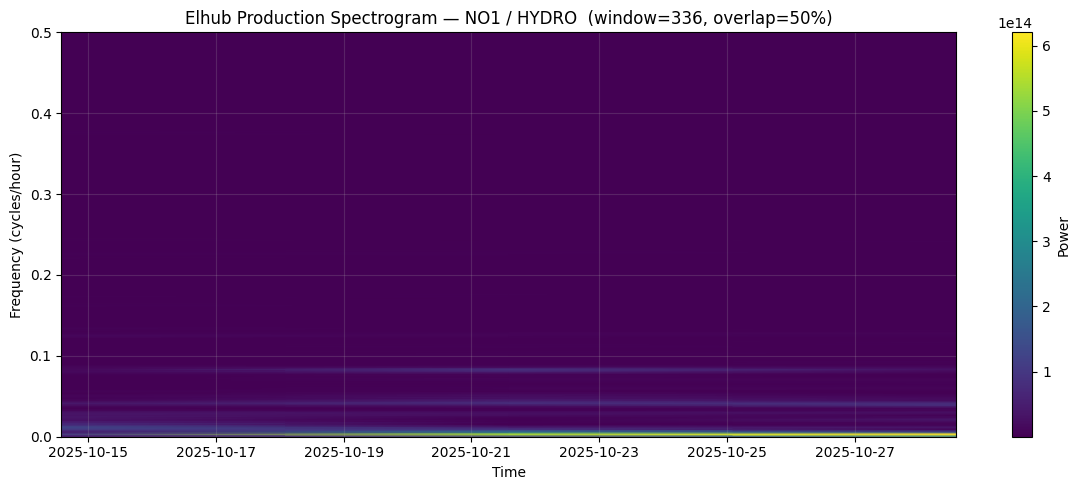

In [ ]:
# This cell is to verify that the functions work as expected
# Also, this is a simple usage example

assert "temperature_2m" in df.columns and "precipitation" in df.columns
print(df.index.min(), df.index.max())  # should cover 2019-01-01 .. 2019-12-31

fig_temp, temp_summary = detect_temperature_outliers(df, freq_cutoff=60, n_std=3.0)
len(temp_summary), temp_summary.columns.tolist()  # expect ['timestamp','temperature_2m','satv','lower_bound','upper_bound']

fig_precip, precip_outliers, precip_summary = detect_precip_lof(df, prop_outliers=0.01)
len(precip_outliers) >= 0; print(precip_summary)

fig_stl, stl_res = stl_decompose_production_elhub(
    elhub_bronze, value_col="quantityKwh",
    price_area="NO5", production_group=None,
    resample_rule="H", period=24, seasonal=13, trend=201, robust=True
)

fig_spec, (f, t_dt, Sxx) = spectrogram_production_elhub(
    elhub_bronze, value_col="quantityKwh",
    price_area="NO1", production_group="HYDRO",
    window_length=24*14, overlap=0.5
)
Sxx.shape
